In [1]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations, product
from tqdm import tqdm

In [2]:
filename = 'test_data/test_lattices/000031220176720822115_SFO2_125_0011_patch_aligned_doseweighted_bin_2.mrc'
threshold_method='sd' 
verbose=True
threads=16
sigma=15 
num_sd=3 
x_window_percent=(0, 0.7)
y_window_percent=(0, 0.995)
mask_hotpixels=False
replace_distance_percent=0.05
return_spots=False

In [3]:
image, header = sax.import_mrc(filename)
padded_fft = sax.scipy_fft(image, verbose, 16)
log_diff_spectrum, smoothed_spectrum = sax.generate_diff_spectrum(padded_fft, sigma)

scipy_fft(): FFT performed in 102.47 milliseconds.


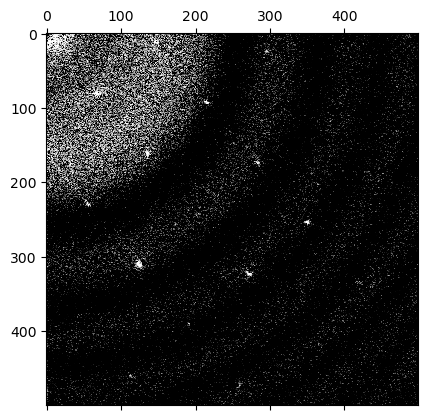

In [4]:
plt.matshow(np.log10(np.abs(padded_fft))[:500, :500],
           cmap = "Greys_r",
           vmax = 3.5,
           vmin = 2.8)

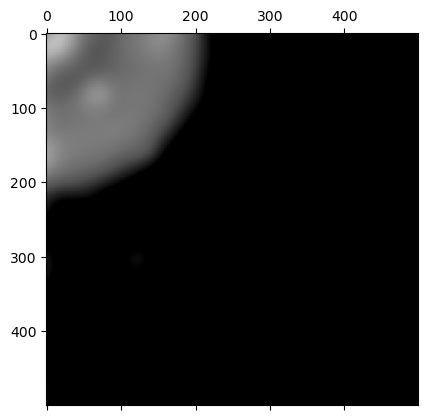

In [5]:
plt.matshow(np.log10(smoothed_spectrum)[:500, :500],
            cmap = "Greys_r",
            vmax = 3.5,
            vmin = 2.8)

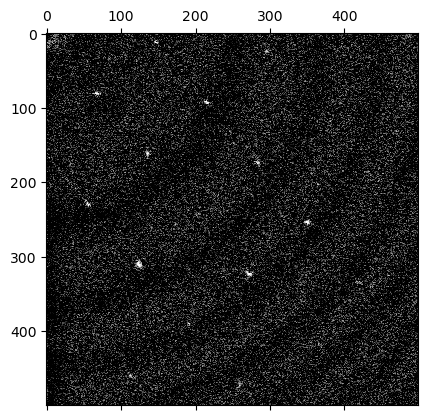

In [6]:
plt.matshow(log_diff_spectrum[0:500, 0:500],
           cmap = "Greys_r",
           vmax = 2,
           vmin = 0)

In [7]:
y_min = int(log_diff_spectrum.shape[0]*y_window_percent[0])
y_max = int(log_diff_spectrum.shape[0]*y_window_percent[1])
x_min = int(log_diff_spectrum.shape[1]*x_window_percent[0])
x_max = int(log_diff_spectrum.shape[1]*x_window_percent[1])

In [8]:
mean = np.mean(log_diff_spectrum[y_min:y_max, x_min:x_max]).flatten()
sd = np.std(log_diff_spectrum[y_min:y_max, x_min:x_max]).flatten()

In [9]:
spot_indices = np.where(log_diff_spectrum >= mean+(num_sd*sd))

In [10]:
spots_in_window = ((spot_indices[0] >= y_min) & (spot_indices[0] <= y_max)) & ((spot_indices[1] >= x_min) & (spot_indices[1] <= x_max))

In [11]:
diffraction_indices = np.array((spot_indices[0][spots_in_window], spot_indices[1][spots_in_window]))

# return diffraction indices

In [12]:
diffraction_amplitudes = np.empty(len(diffraction_indices[0]))
for i in range(len(diffraction_indices[0])):
    diffraction_amplitudes[i] = log_diff_spectrum[diffraction_indices[0,i], diffraction_indices[1, i]]
    
    # return diffraction_amplitudes 

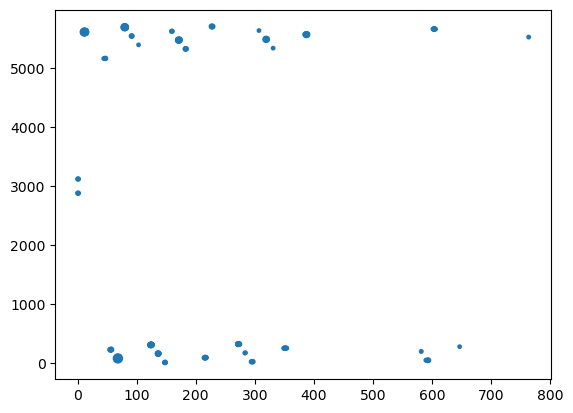

In [13]:
plt.scatter(y = diffraction_indices[0,:], x = diffraction_indices[1,:], s = np.exp(diffraction_amplitudes))

In [14]:
# Find a way to wrap back around...
wrapped_indices = np.copy(diffraction_indices)
for i in range(len(diffraction_indices[0])):
    if diffraction_indices[0, i] > (np.max(log_diff_spectrum.shape)/2):
        wrapped_indices[0, i] = diffraction_indices[0, i] - np.max(log_diff_spectrum.shape)


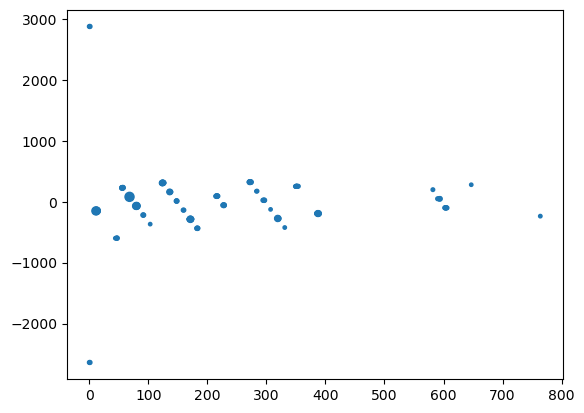

In [15]:
plt.scatter(y = wrapped_indices[0,:], x = wrapped_indices[1,:], s = np.exp(diffraction_amplitudes))

In [16]:
# Find the top eight brightest points

top_eight = np.flip(np.argsort(diffraction_amplitudes))[0:8]

basis_points = wrapped_indices[:,top_eight]

# Add error terms, weighted by strength of peaks and
# Angle between vectors

best_error = 1e8
best_basis = np.empty((2, 2))
best_miller = np.empty(wrapped_indices.shape)

for i in range(8):
    for j in range((i+1), 8):
        
        # Establish the basis matrix
        basis_matrix = basis_points[:,(i,j)]
        
        # Take the inverse
        inverse_matrix = np.linalg.inv(basis_matrix)
        
        # Transform all peaks into this basis
        miller_matrix = np.matmul(inverse_matrix, wrapped_indices)
        
        # Compute the sum of the (amplitude peaks * (x_error^2 + y_error^2))
        basis_error = np.sum(np.exp(diffraction_amplitudes)*np.sum((miller_matrix - np.round(miller_matrix))**2,
                                                            axis=0))
    
        # Compute the angle between the vectors
        angle = (360/(2*np.pi))*np.arccos(np.dot(basis_matrix[:,0], basis_matrix[:,1])/
                          (np.linalg.norm(basis_matrix[:,0])*np.linalg.norm(basis_matrix[:,1])))
        
        # Impose angle penalty if angle is less than 10 degrees
        if angle <= 10: 
            angle_penalty = np.exp(10-angle)
        else:
            angle_penalty = 1
        
        # Compute the overall error for the basis: angle_penalty*sum(amplitude peaks * (x_error^2 + y_error^2))
        error = angle_penalty*basis_error
        
        # Store the choice of basis vectors
        if error < best_error:
            best_error = error
            best_basis = basis_matrix
            best_miller = miller_matrix

In [17]:
# the 2dx paper here mentions finding the shortest lattice
# with part of the algorithm that I don't understand
# going to ignore this part for now and see what happens...

In [18]:
# Discard the points that don't fall within a
# fraction of an integer miller index

epsilon = 0.0707
filtered_points_logical = np.logical_and((np.abs(best_miller - np.round(best_miller)) <= epsilon)[0,:],
                                        (np.abs(best_miller - np.round(best_miller)) <= epsilon)[1,:])
filtered_miller = best_miller[:,filtered_points_logical]

In [19]:
# Now, we need to get rid of redundant points

# For each unique set of miller indices

# 1. Pull a subset of redundant peaks
# 2. See which is closest to the true location
# 3. Put that point in a new list

unique_miller = np.unique(np.round(filtered_miller), axis=1)
best_fit_spots = []

# For each unique set of miller indices
# for miller in np.transpose(unique_miller):

for miller in np.transpose(unique_miller):
    # Pull a subset of matching peaks
    redundant_miller = filtered_miller[:,np.where((np.round(filtered_miller)[0,:] == miller[0]) & (np.round(filtered_miller)[1,:] == miller[1]))[0]]

    # See which is closest to the true location
    best_spot = np.argmin((redundant_miller[0,:] - miller[0])**2 + (redundant_miller[1,:] - miller[1])**2)

    # Keep the best point
    best_fit_spots.append(redundant_miller[:,best_spot])

In [20]:
# Recreate the best-fit points in Fourier space
best_fit_miller_array = np.transpose(np.stack(best_fit_spots))
best_fit_indices = np.matmul(best_basis, best_fit_miller_array)

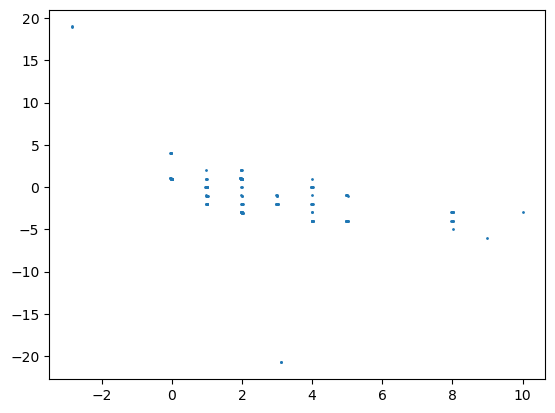

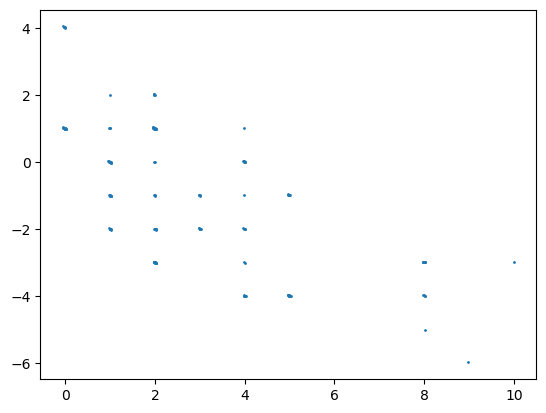

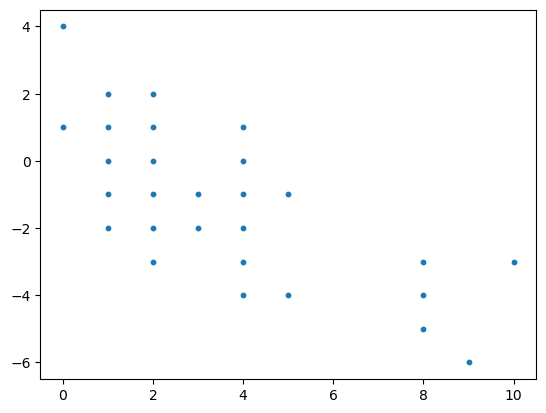

In [21]:
# Plot the filtered miller indices
plt.scatter(y = best_miller[0,:], x = best_miller[1,:], s = 1)
plt.show()
plt.scatter(y = filtered_miller[0,:], x = filtered_miller[1,:], s = 1)
plt.show()
plt.scatter(y = unique_miller[0,:], x = unique_miller[1,:], s = 10)
plt.show()

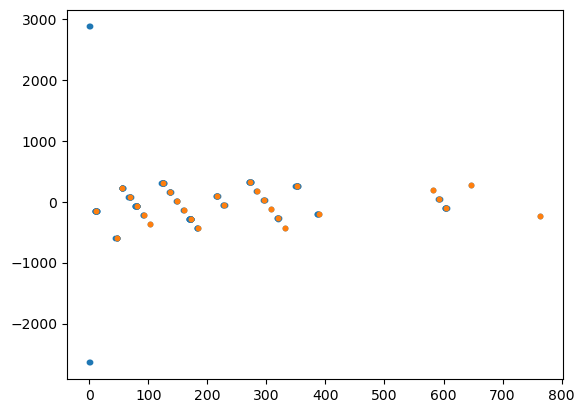

In [22]:
# Plot the best predicted lattice overtop of the experimental lattice

fig, ax = plt.subplots()

ax.scatter(y = wrapped_indices[0,:], x = wrapped_indices[1,:], s = 10)
ax.scatter(y = best_fit_indices[0,:], x = best_fit_indices[1,:], s = 10)
#ax.set_ylim(-250, 250)
#ax.set_xlim(0, 250)

In [23]:
# # LSQ fit to refine the xtal lattice

# # Variables we need: best_fit_miller_array (rounded),

# lsq_miller_array = np.round(best_fit_miller_array)
# lsq_basis = best_basis
# lsq_indices = best_fit_indices

# NN_t_inv = np.linalg.inv(np.matmul(lsq_miller_array,np.transpose(lsq_miller_array)))
# N = lsq_miller_array
# X_t = np.transpose(lsq_indices)

# refined_basis = np.transpose(np.matmul(np.matmul(NN_t_inv, N), X_t))

In [24]:
lowest_miller_index = int(np.min(np.round(best_fit_miller_array))) - 2
highest_miller_index = int(np.max(np.round(best_fit_miller_array))) + 2
permute_list = np.linspace(lowest_miller_index, highest_miller_index, (highest_miller_index-lowest_miller_index)+1).tolist()

In [25]:
test_miller = np.transpose(np.array(list(product(permute_list, repeat=2))))

In [26]:
test_indices = np.matmul(best_basis, test_miller)

In [27]:
# Make sure x-coordinates are in range

inrange_indices = test_indices[:,np.where(test_indices[1,:] > 10)]
inrange_indices = inrange_indices[:,0,:]

In [28]:
inrange_indices[:,61]

array([107., 364.])

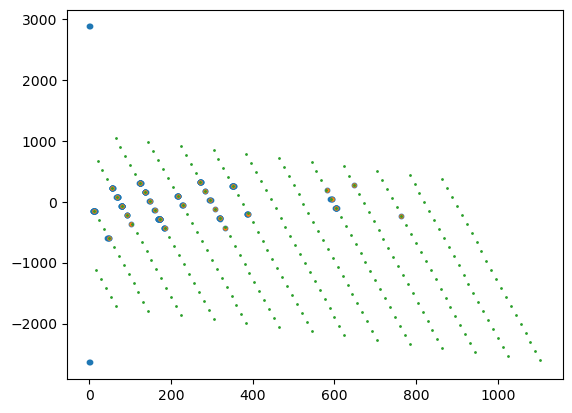

In [29]:
fig, ax = plt.subplots()

ax.scatter(y = wrapped_indices[0,:], x = wrapped_indices[1,:], s = 10)
ax.scatter(y = best_fit_indices[0,:], x = best_fit_indices[1,:], s = 5)
ax.scatter(y = inrange_indices[0,:], x = inrange_indices[1,:], s = 1)
# ax.set_ylim(-1500, 1500)
# ax.set_xlim(-0, 1500)

In [30]:
# Unwrap the indices to extract boxes

unwrapped_indices = np.copy(inrange_indices)

for i in range(len(inrange_indices[0])):
    if inrange_indices[0, i] < 0:
        unwrapped_indices[0, i] = inrange_indices[0, i] + np.max(log_diff_spectrum.shape)


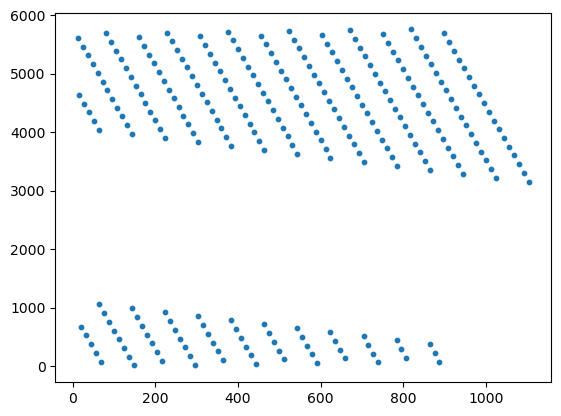

In [31]:
fig, ax = plt.subplots()

ax.scatter(y = unwrapped_indices[0,:], x = unwrapped_indices[1,:], s = 10)

In [49]:
# inrange_indices is a list of places in the image we need to filter.
# Write a loop over all index pairs that finds and plots 5x5 areas
# around each inrange_index

new_points = []

for i in range(unwrapped_indices.shape[1]):
    
    # Figure out which indices we're working with
    view_indices = unwrapped_indices[:,i].astype(int)
    
    # extract the box
    view_array = log_diff_spectrum[(view_indices[0]-10):(view_indices[0]+11),
                                   (view_indices[1]-10):(view_indices[1]+11)]
    
    # Look for points >2 SD above the background
    mean = np.mean(view_array)
    sd = np.std(view_array)
    
    # If a point is found
    if(np.sum(view_array >= mean + 2*sd) > 0):
        
        # Find their indices
        relative_indices = np.where(view_array >= mean + 2*sd)
        
        # Adjust them relative to the starting index
        absolute_indices = np.copy(relative_indices)
        absolute_indices[0] = relative_indices[0] + (view_indices[0]-10)
        absolute_indices[1] = relative_indices[1] + (view_indices[1]-10)
        new_points.append(absolute_indices)

In [50]:
# Combine the new candidate points with the old points, filter for unique points
new_points_array = np.concatenate(new_points, axis=1)
combined_points = np.unique(np.hstack((best_fit_indices, new_points_array)), axis=1)

In [51]:
# Unwrap all the indices to extract amplitudes

combined_points_amp = np.copy(combined_points)

for i in range(len(combined_points[0])):
    if combined_points[0, i] < 0:
        combined_points_amp[0, i] = combined_points[0, i] + np.max(log_diff_spectrum.shape)

combined_points_amp = combined_points_amp.astype(int)

In [52]:
combined_points_amp[0,:]

array([5163, 5325, 5337, 5393, 5475, 5487, 5524, 5542, 5567, 5611, 5623,
       5635, 5661, 5692, 5704,    9,   11,   11,   12,   12,   12,   12,
         13,   13,   13,   14,   24,   24,   25,   25,   25,   25,   32,
         39,   39,   48,   49,   49,   49,   49,   49,   49,   50,   50,
         50,   50,   50,   79,   80,   80,   80,   81,   81,   81,   81,
         81,   82,   92,   92,   92,   93,   93,   93,   93,   94,   94,
         94,  119,  155,  161,  161,  161,  162,  162,  162,  162,  162,
        163,  172,  173,  173,  173,  173,  174,  174,  174,  174,  175,
        175,  175,  198,  198,  199,  199,  199,  199,  199,  211,  211,
        225,  227,  228,  228,  229,  229,  229,  230,  230,  230,  231,
        231,  234,  234,  242,  245,  252,  253,  253,  253,  253,  253,
        254,  254,  254,  254,  254,  254,  255,  255,  255,  255,  256,
        256,  270,  279,  279,  280,  280,  280,  280,  280,  292,  308,
        308,  309,  309,  310,  310,  310,  311,  3

In [53]:
# Extract the respective amplitudes for combined_wrapped_indices from log_diff_spectrum

combined_amplitudes = log_diff_spectrum[combined_points_amp[0,:], combined_points_amp[1,:]]

In [54]:
# Rerun existing pipeline on combined_points!

# Find a way to wrap back around...
combined_wrapped_indices = np.copy(combined_points)
for i in range(len(combined_points[0])):
    if combined_points[0, i] > (np.max(log_diff_spectrum.shape)/2):
        combined_wrapped_indices[0, i] = combined_points[0, i] - np.max(log_diff_spectrum.shape)


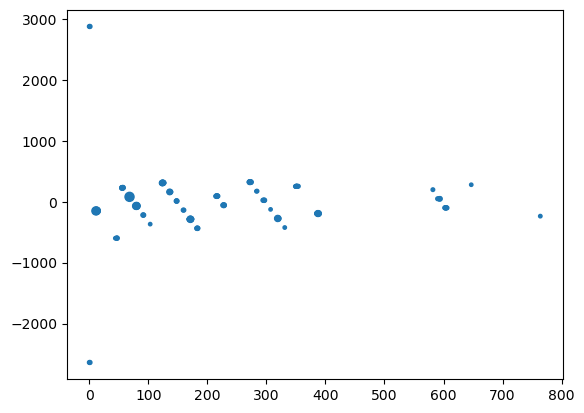

In [55]:
# Plot without the combined points

plt.scatter(y = wrapped_indices[0,:], x = wrapped_indices[1,:], s = np.exp(diffraction_amplitudes))

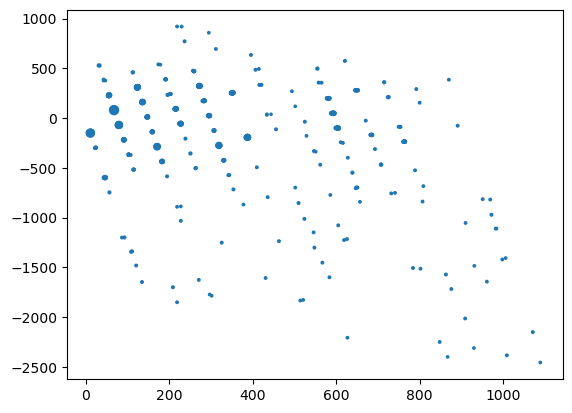

In [56]:
# Plot with the combined points
# Weighted by amplitude

plt.scatter(y = combined_wrapped_indices[0,:], x = combined_wrapped_indices[1,:], s = np.exp(combined_amplitudes))

In [57]:
# Find the top eight brightest points

top_eight = np.flip(np.argsort(combined_amplitudes))[0:8]

basis_points = combined_wrapped_indices[:,top_eight]

# Add error terms, weighted by strength of peaks and
# Angle between vectors

best_error = 1e8
best_basis = np.empty((2, 2))
best_miller = np.empty(wrapped_indices.shape)

for i in range(8):
    for j in range((i+1), 8):
        
        # Establish the basis matrix
        basis_matrix = basis_points[:,(i,j)]
        
        # Take the inverse
        inverse_matrix = np.linalg.inv(basis_matrix)
        
        # Transform all peaks into this basis
        miller_matrix = np.matmul(inverse_matrix, wrapped_indices)
        
        # Compute the sum of the (amplitude peaks * (x_error^2 + y_error^2))
        basis_error = np.sum(np.exp(diffraction_amplitudes)*np.sum((miller_matrix - np.round(miller_matrix))**2,
                                                            axis=0))
    
        # Compute the angle between the vectors
        angle = (360/(2*np.pi))*np.arccos(np.dot(basis_matrix[:,0], basis_matrix[:,1])/
                          (np.linalg.norm(basis_matrix[:,0])*np.linalg.norm(basis_matrix[:,1])))
        
        # Impose angle penalty if angle is less than 10 degrees
        if angle <= 10: 
            angle_penalty = np.exp(10-angle)
        else:
            angle_penalty = 1
        
        # Compute the overall error for the basis: angle_penalty*sum(amplitude peaks * (x_error^2 + y_error^2))
        error = angle_penalty*basis_error
        
        # Store the choice of basis vectors
        if error < best_error:
            best_error = error
            best_basis = basis_matrix
            best_miller = miller_matrix

In [58]:
# Discard the points that don't fall within a
# fraction of an integer miller index

epsilon = 0.0707
filtered_points_logical = np.logical_and((np.abs(best_miller - np.round(best_miller)) <= epsilon)[0,:],
                                        (np.abs(best_miller - np.round(best_miller)) <= epsilon)[1,:])
filtered_miller = best_miller[:,filtered_points_logical]

In [59]:
# Now, we need to get rid of redundant points

# For each unique set of miller indices

# 1. Pull a subset of redundant peaks
# 2. See which is closest to the true location
# 3. Put that point in a new list

unique_miller = np.unique(np.round(filtered_miller), axis=1)
best_fit_spots = []

# For each unique set of miller indices
# for miller in np.transpose(unique_miller):

for miller in np.transpose(unique_miller):
    # Pull a subset of matching peaks
    redundant_miller = filtered_miller[:,np.where((np.round(filtered_miller)[0,:] == miller[0]) & (np.round(filtered_miller)[1,:] == miller[1]))[0]]

    # See which is closest to the true location
    best_spot = np.argmin((redundant_miller[0,:] - miller[0])**2 + (redundant_miller[1,:] - miller[1])**2)

    # Keep the best point
    best_fit_spots.append(redundant_miller[:,best_spot])

In [60]:
# Recreate the best-fit points in Fourier space
best_fit_miller_array = np.transpose(np.stack(best_fit_spots))
best_fit_indices = np.matmul(best_basis, best_fit_miller_array)

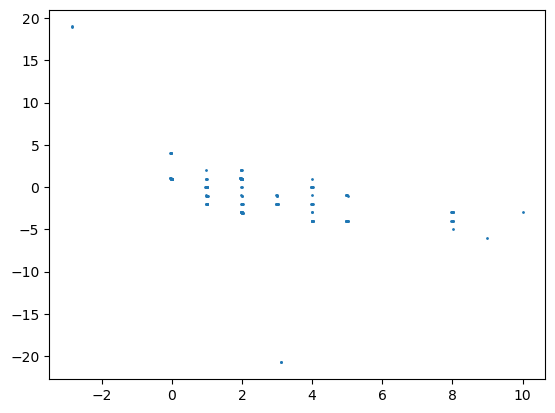

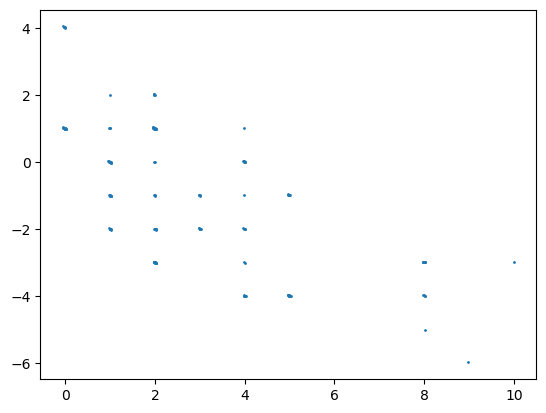

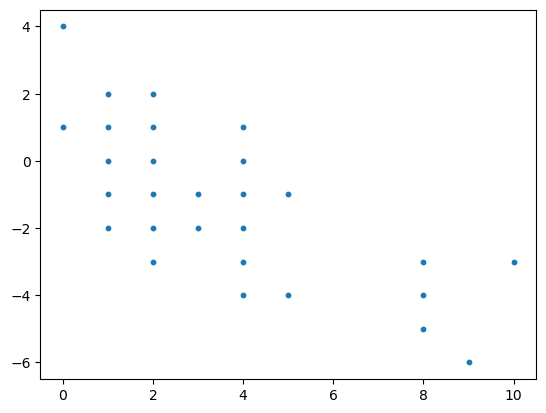

In [61]:
# Plot the filtered miller indices
plt.scatter(y = best_miller[0,:], x = best_miller[1,:], s = 1)
plt.show()
plt.scatter(y = filtered_miller[0,:], x = filtered_miller[1,:], s = 1)
plt.show()
plt.scatter(y = unique_miller[0,:], x = unique_miller[1,:], s = 10)
plt.show()

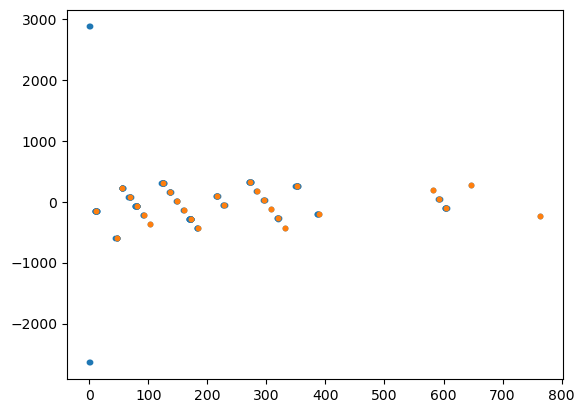

In [62]:
# Plot the best predicted lattice overtop of the experimental lattice

fig, ax = plt.subplots()

ax.scatter(y = wrapped_indices[0,:], x = wrapped_indices[1,:], s = 10)
ax.scatter(y = best_fit_indices[0,:], x = best_fit_indices[1,:], s = 10)
#ax.set_ylim(-250, 250)
#ax.set_xlim(0, 250)

In [70]:
# Calculate the resolution of the farthest lattice spot

psize = 1.048
num_pix = np.max(padded_fft.shape)
max_rad = np.max(np.sqrt((best_fit_indices[0,:]**2 + best_fit_indices[1,:]**2)))

highest_resolution = psize*num_pix/max_rad
print(highest_resolution)

7.549186715737373


In [ ]:
# Generate a list of 5x5 indices around each detected spot and pass that to replace_diffraction_spots()

In [ ]:
# We could extend the program by looking for multiple lattices
# Or by